This runs all segmentation operations in one place.
The idea is that this should be faster and easier to envoke as we only have to load the image data once instead of N times (~10).
Running each individual task as its own script is modular but requires overhead to load the data each time.
Currently it takes about 15 minutes to complete a single organoid's segmentation for all compartments... (~50,1500,1500) (Z,Y,X) dimensional image. 
Let us see how long this takes!

No we are at ~8 minutes!

In [1]:
import argparse
import os
import pathlib
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import scipy
import tifffile
import torch
from arg_parsing_utils import check_for_missing_args, parse_args
from cellpose import models
from file_reading import *
from file_reading import read_zstack_image
from general_segmentation_utils import *
from notebook_init_utils import bandicoot_check, init_notebook
from organoid_segmentation import *
from segmentation_decoupling import *
from skimage.filters import sobel

In [2]:
start_time = time.time()
# get starting memory (cpu)
start_mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2

In [3]:
root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

In [4]:
if not in_notebook:
    args = parse_args()
    clip_limit = args["clip_limit"]
    well_fov = args["well_fov"]
    patient = args["patient"]
    input_subparent_name = args["input_subparent_name"]
    mask_subparent_name = args["mask_subparent_name"]
    check_for_missing_args(
        well_fov=well_fov,
        patient=patient,
        clip_limit=clip_limit,
        input_subparent_name=input_subparent_name,
        mask_subparent_name=mask_subparent_name,
    )
else:
    print("Running in a notebook")
    patient = "NF0014_T1"
    well_fov = "D10-1"
    clip_limit = 0.01
    input_subparent_name = "zstack_images"
    mask_subparent_name = "segmentation_masks"


window_size = 2
input_dir = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{input_subparent_name}/{well_fov}"
).resolve(strict=True)
mask_path = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{mask_subparent_name}/{well_fov}"
).resolve()
mask_path.mkdir(exist_ok=True, parents=True)

Running in a notebook


In [5]:
return_dict = read_in_channels(
    find_files_available(input_dir),
    channel_dict={
        "nuclei": "405",
        "cyto1": "488",
        "cyto2": "555",
        "cyto3": "640",
        "brightfield": "TRANS",
    },
    channels_to_read=["cyto2"],
)
cyto2_raw = return_dict["cyto2"]
del return_dict
nuclei_mask_output = pathlib.Path(f"{mask_path}/nuclei_mask.tiff")
nuclei_mask = read_zstack_image(nuclei_mask_output)
# run clip_limit here
cyto2 = skimage.exposure.equalize_adapthist(
    cyto2_raw, clip_limit=clip_limit, kernel_size=None
)
del cyto2_raw

KeyboardInterrupt: 

## Organoid segmentation
Commented out as this segmentation is now derived from cell segmentation.
This is done in a separate notebook `1a.organoid_segmentation_derived_from_cell.ipynb`.
This code is effectively deprecated.

In [ ]:
# cyto2_image_shape = cyto2.shape
# # commenting out optimization for time being
# # uncomment to run optimization
# # butterworth_grid_optimization(two_point_five_D_sliding_window, return_plot=False)

# filtered_cyto2 = apply_butterworth_filter(
#     sliding_window_two_point_five_D(cyto2, window_size=window_size),  # cyto
#     cutoff_frequency_ratio=0.05,
#     order=1,
#     high_pass=False,
#     squared_butterworth=True,
# )
# model = models.CellposeModel(
#     gpu=[True if torch.cuda.is_available() else False][0],
#     model_type="cyto3",  # CP3
# )
# output_dict = {
#     "slice": [],
#     "labels": [],
#     "details": [],
# }
# for slice in tqdm.tqdm(range(filtered_cyto2.shape[0])):
#     labels, details, _ = segment_with_diameter(
#         filtered_cyto2[slice],
#         model=model,
#         diameter=750,
#         z_axis=0,
#         channels=[1, 0],
#         min_diameter=200,  # default 200
#         diameter_step=200,  # default 200
#     )
#     output_dict["slice"].append(slice)
#     output_dict["labels"].append(labels)
#     output_dict["details"].append(details)

# del filtered_cyto2

In [ ]:
# organoid_masks = np.array(
#     list(
#         decouple_masks(
#             reverse_sliding_window_max_projection(
#                 output_dict,
#                 window_size=window_size,
#                 original_z_slice_count=cyto2_image_shape[0],
#             ),
#             original_img_shape=cyto2_image_shape,
#             distance_threshold=40,
#         ).values()
#     )
# )

In [ ]:
# # generate the coordinates dataframe for reconstruction
# coordinates_df = generate_coordinates_for_reconstruction(organoid_masks)
# # generate distance pairs dataframe
# df = generate_distance_pairs(coordinates_df, x_y_vector_radius_max_constraint=20)
# # create and solve graph to get longest paths
# longest_paths = solve_graph(graph_creation(df))
# # collapse labels based on longest paths and reassign labels in organoid masks
# image = reassign_labels(organoid_masks, collapse_labels(coordinates_df, longest_paths))
# # refine the organoid masks
# organoid_mask = run_post_hoc_refinement(
#     mask_image=image,
#     sliding_window_context=3,
# )
# # clean up and send to gc
# del image, coordinates_df, df, longest_paths

## Segment the cells

In [ ]:
# def segment_cells_with_3D_watershed(
#     cyto_signal: np.ndarray,
#     nuclei_mask: np.ndarray,
# ) -> np.ndarray:
#     # gaussian filter to smooth the image
#     cell_signal_image = skimage.filters.gaussian(cyto_signal, sigma=1.0)
#     # scale the pixels to max 255
#     nuclei_mask = (nuclei_mask / nuclei_mask.max() * 255).astype(np.uint8)
#     # generate the elevation map using the Sobel filter
#     elevation_map = sobel(cell_signal_image)

#     # set up seeded watersheding where the nuclei masks are used as seeds
#     # note: the cytoplasm is used as the signal for this.

#     labels = skimage.segmentation.watershed(
#         image=elevation_map,
#         markers=nuclei_mask,
#     )

#     # change the largest label (by area) to 0
#     # cleans up the output and sets the background properly
#     unique, counts = np.unique(labels, return_counts=True)
#     largest_label = unique[np.argmax(counts)]
#     labels[labels == largest_label] = 0
#     cell_mask = labels.copy()
#     # cell_mask = run_post_hoc_refinement(
#     #     mask_image=cell_mask,
#     #     sliding_window_context=3,
#     # )
#     return labels

In [ ]:
cmap_option = "magma"

In [ ]:
# elevation_map_1 = skimage.filters.butterworth(
#     cyto2,
#     cutoff_frequency_ratio=0.08,
#     order=2,
#     high_pass=False,
#     squared_butterworth=False,
# )
# elevation_map_2 = skimage.filters.butterworth(
#     cyto2,
#     cutoff_frequency_ratio=0.08,
#     order=2,
#     high_pass=True,
#     squared_butterworth=False,
# )
# plt.figure(figsize=(12, 8))
# plt.subplot(131)
# plt.imshow(cyto2[cyto2.shape[0] // 2], cmap=cmap_option)
# plt.title("Cyto2 Image")
# plt.axis('off')
# plt.subplot(132)
# plt.imshow(elevation_map_1[cyto2.shape[0] // 2], cmap=cmap_option)
# plt.title("Low-pass Butterworth filter")
# plt.axis('off')
# plt.subplot(133)
# plt.imshow(elevation_map_2[cyto2.shape[0] // 2], cmap=cmap_option)
# plt.title("High-pass Butterworth filter")
# plt.axis('off')
# plt.show()

In [ ]:
# # threshold the elevation maps
# threshold_1 = skimage.filters.threshold_otsu(cyto2)
# threshold_2 = skimage.filters.threshold_otsu(elevation_map_1)
# threshold_3 = skimage.filters.threshold_otsu(elevation_map_2)
# binary_map_1 = cyto2 > threshold_1
# binary_map_2 = elevation_map_1 > threshold_2
# binary_map_3 = elevation_map_2 > threshold_3

# max_proj = np.max([
#     binary_map_1,
#     binary_map_2,
#     # binary_map_3
#     ], axis=0)
# # dialte the max projection for better visualization
# max_proj = skimage.morphology.binary_dilation(
#     max_proj,
#     skimage.morphology.ball(2),
# )
# signal_from_max_proj = cyto2.copy()
# signal_from_max_proj[max_proj == False] = 0


# plt.figure(figsize=(12, 8))
# plt.subplot(241)
# plt.imshow(binary_map_1[cyto2.shape[0] // 2], cmap=cmap_option)
# plt.title("Binary Map - No filter")
# plt.axis('off')
# plt.subplot(242)
# plt.imshow(binary_map_2[cyto2.shape[0] // 2], cmap=cmap_option)
# plt.title("Binary Map - Low-pass")
# plt.axis('off')
# plt.subplot(243)
# plt.imshow(binary_map_3[cyto2.shape[0] // 2], cmap=cmap_option)
# plt.title("Binary Map - High-pass")
# plt.axis('off')
# plt.subplot(244)
# plt.imshow(max_proj[cyto2.shape[0] // 2], cmap=cmap_option)
# plt.title("Max Projection of Binary Maps")
# plt.axis('off')
# plt.subplot(245)
# plt.imshow(cyto2[cyto2.shape[0] // 2], cmap=cmap_option)
# plt.title("Cyto2 Image")

# plt.axis('off')
# plt.subplot(246)
# plt.imshow(elevation_map_1[cyto2.shape[0] // 2], cmap=cmap_option)
# plt.title("Elevation Map - Low-pass")

# plt.axis('off')
# plt.subplot(247)
# plt.imshow(elevation_map_2[cyto2.shape[0] // 2], cmap=cmap_option)
# plt.title("Elevation Map - High-pass")
# plt.axis('off')
# plt.subplot(248)
# plt.imshow(signal_from_max_proj[cyto2.shape[0] // 2], cmap=cmap_option)
# plt.title("Signal from Max Projection")
# plt.axis('off')
# plt.show()

In [ ]:
# # # set up proper distance transform and gradient descent parameters
# # cell_signal_image = skimage.filters.gaussian(cyto2, sigma=1.0)
# # elevation_map = skimage.filters.sobel(cell_signal_image)
# nuclei_mask_scaled = skimage.measure.label(nuclei_mask > 0)
# # # remove background marker
# # # get the markers
# # elevation_map = elevation_map_1
# # labels = skimage.segmentation.watershed(
# #     image=elevation_map,
# #     markers=nuclei_mask,
# #     # connectivity=1
# # )
# # unique, counts = np.unique(labels, return_counts=True)
# # largest_label = unique[np.argmax(counts)]
# # print(f"Largest label to remove: {largest_label}")
# # labels[labels == largest_label] = 0

# # cyto_signal=cyto2
# # cyto_signal=elevation_map_1
# cyto_signal=signal_from_max_proj
# # cyto_signal=max_proj

# cell_mask = segment_cells_with_3D_watershed(
#     cyto_signal=cyto_signal,
#     nuclei_mask=nuclei_mask_scaled,
# )


# for z in range(cyto2.shape[0]):
#     # z=cyto2.shape[0] // 2
#     plt.figure(figsize=(12, 8))
#     plt.subplot(131)
#     plt.title("Nuclei mask")
#     plt.imshow(nuclei_mask[z], cmap=cmap_option)
#     plt.axis('off')
#     plt.subplot(132)
#     plt.title("Cell Mask - Watershed")
#     plt.imshow(cell_mask[z], cmap=cmap_option)
#     plt.axis('off')
#     plt.subplot(133)
#     plt.title("Elevation Map")
#     plt.imshow(cyto_signal[z], cmap=cmap_option)
#     plt.axis('off')
#     plt.show()

## Fill holes on a per label basis 

In [14]:
# # loop through each z-slice and fill holes for each label individually

# # loop through each z-slice
# for z in range(cell_mask.shape[0]):
#     # copy this slice
#     cell_mask_slice = cell_mask[z,:,:].copy()
#     # get the labels present in this slice
#     labels = np.unique(cell_mask_slice)
#     # loop through each label and fill holes
#     slice_images_to_max_proj = []
#     for label in labels:
#         # copt the slice so we can isolate the label
#         cell_mask_slice_single_label = cell_mask_slice.copy()
#         # isolate the label
#         cell_mask_slice_single_label[cell_mask_slice_single_label != label] = 0
#         # fill the holes
#         cell_mask_slice_single_label = scipy.ndimage.binary_fill_holes(cell_mask_slice_single_label)
#         cell_mask_cleaned = skimage.morphology.binary_closing(
#             cell_mask_slice_single_label > 0,  # Convert to binary
#             skimage.morphology.disk(10)  # Adjust radius to speckle size
#         )
#         # remove small objects
#         cell_mask_cleaned = skimage.morphology.remove_small_objects(
#             cell_mask_cleaned,
#             min_size=100,  # Adjust size threshold as needed
#         )
#         # remove large objects
#         labeled_temp = skimage.measure.label(cell_mask_cleaned)
#         props = skimage.measure.regionprops(labeled_temp)
#         for prop in props:
#             if prop.area > 250000: # 500 x 500 pixel artifacts (50umx50um)  # Adjust threshold
#                 cell_mask_cleaned[labeled_temp == prop.label] = 0
#             cell_mask_cleaned = cell_mask_cleaned.astype(np.uint16)
#         # reassign the label such that it is the original label and not binary
#         cell_mask_cleaned[cell_mask_cleaned > 0] = label
#         slice_images_to_max_proj.append(cell_mask_cleaned)
#     # max project the slice images to get the final filled slice
#     cell_mask_slice_max_proj = np.max(np.array(slice_images_to_max_proj), axis=0)
#     # overwrite the original slice with the filled slice
#     cell_mask[z,:,:] = cell_mask_slice_max_proj
# for z in range(cell_mask.shape[0]):
#     # z=cyto2.shape[0] // 2
#     plt.figure(figsize=(12, 8))
#     plt.title("cell_mask")
#     plt.imshow(cell_mask[z], cmap=cmap_option)
#     plt.axis('off')
#     plt.show()

## Cell SAM for cell segmentation

In [15]:
import os

import imageio.v3 as iio
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from cellSAM import cellsam_pipeline, get_model
from cellSAM.utils import format_image_shape, normalize_image

# show the access token is set
# print("DEEPCELL_ACCESS_TOKEN set:", "DEEPCELL_ACCESS_TOKEN" in os.environ)
# print(os.environ["DEEPCELL_ACCESS_TOKEN"])
# get_model()

/home/lippincm/miniforge3/envs/GFF_segmentation/lib/python3.11/site-packages/cellSAM/sam_inference.py:351: UserWarning: Low IOU threshold, ignoring mask.
  warnings.warn("Low IOU threshold, ignoring mask.")
/home/lippincm/miniforge3/envs/GFF_segmentation/lib/python3.11/site-packages/cellSAM/sam_inference.py:351: UserWarning: Low IOU threshold, ignoring mask.
  warnings.warn("Low IOU threshold, ignoring mask.")
/home/lippincm/miniforge3/envs/GFF_segmentation/lib/python3.11/site-packages/cellSAM/sam_inference.py:351: UserWarning: Low IOU threshold, ignoring mask.
  warnings.warn("Low IOU threshold, ignoring mask.")
/home/lippincm/miniforge3/envs/GFF_segmentation/lib/python3.11/site-packages/cellSAM/sam_inference.py:351: UserWarning: Low IOU threshold, ignoring mask.
  warnings.warn("Low IOU threshold, ignoring mask.")
/home/lippincm/miniforge3/envs/GFF_segmentation/lib/python3.11/site-packages/cellSAM/sam_inference.py:351: UserWarning: Low IOU threshold, ignoring mask.
  warnings.warn("L

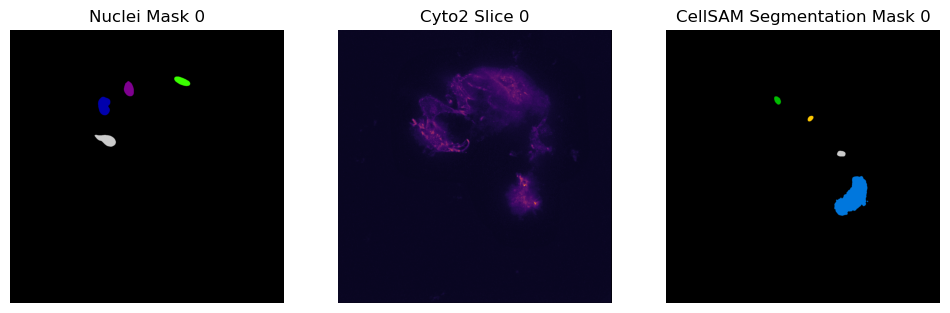

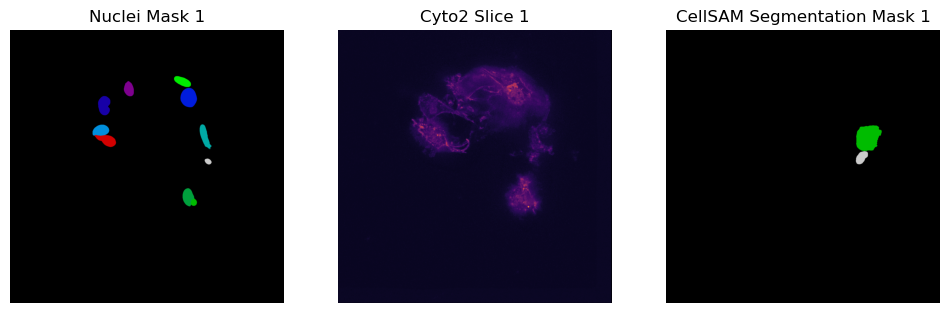

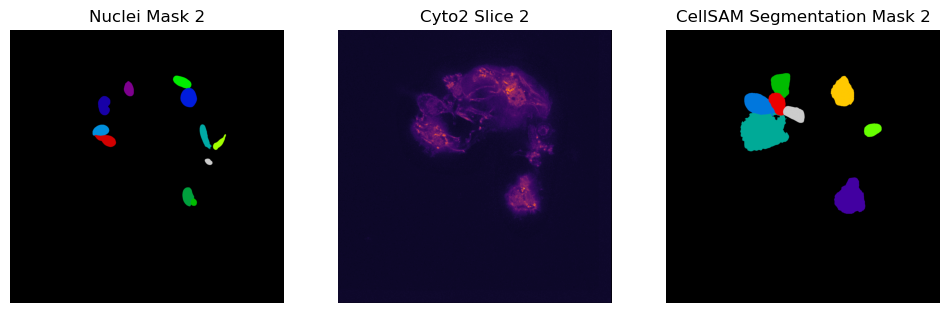

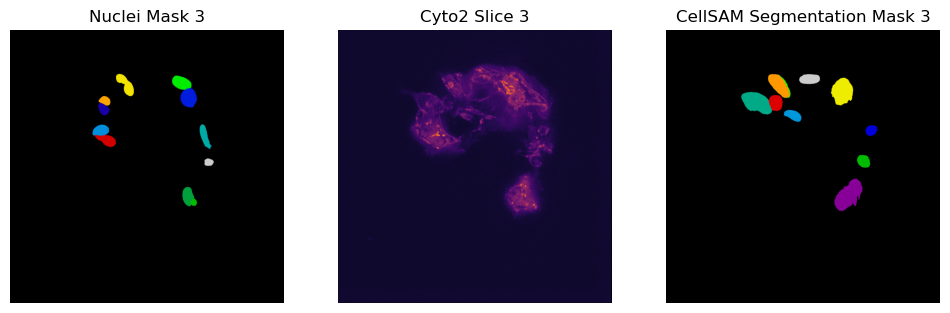

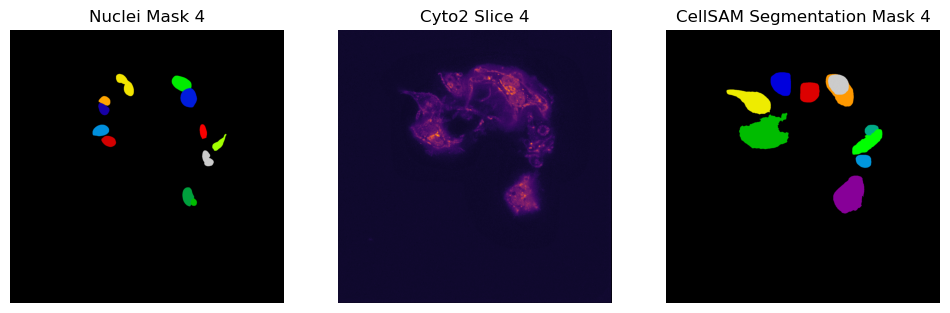

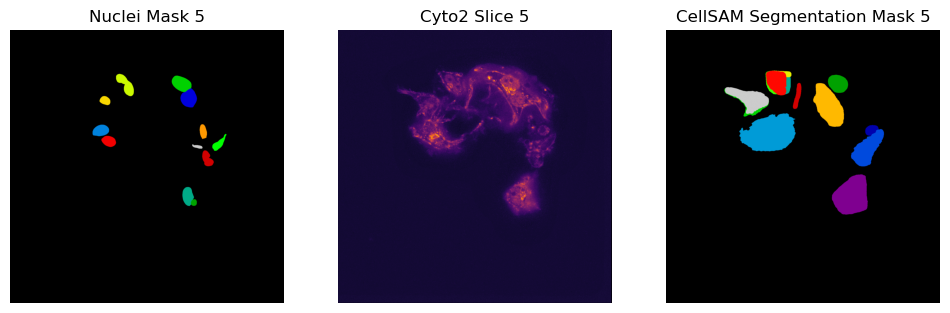

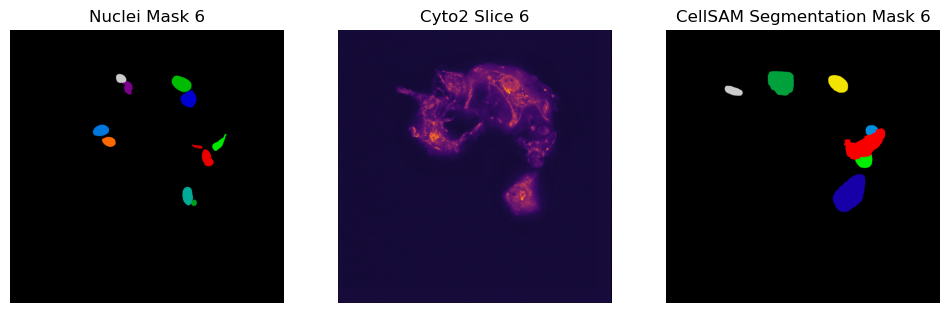

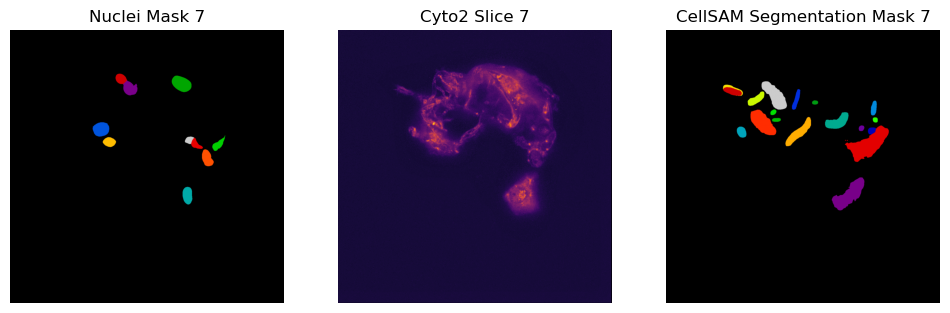

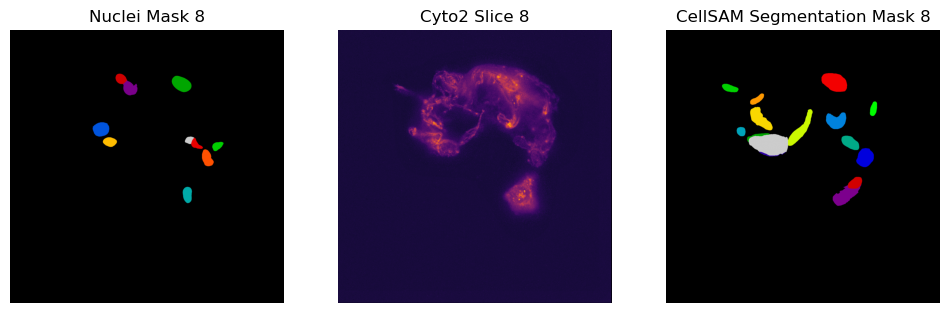

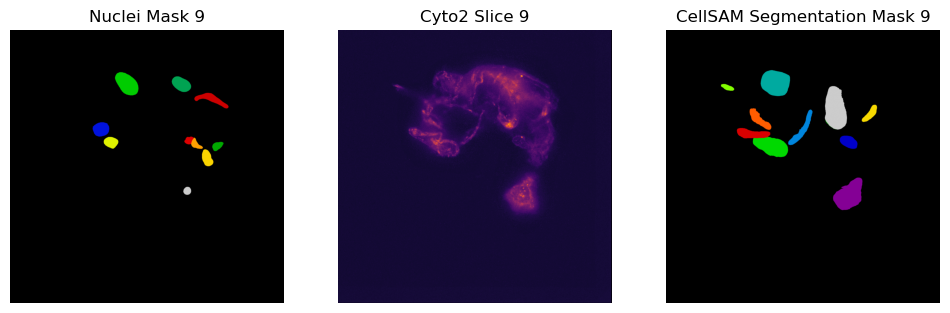

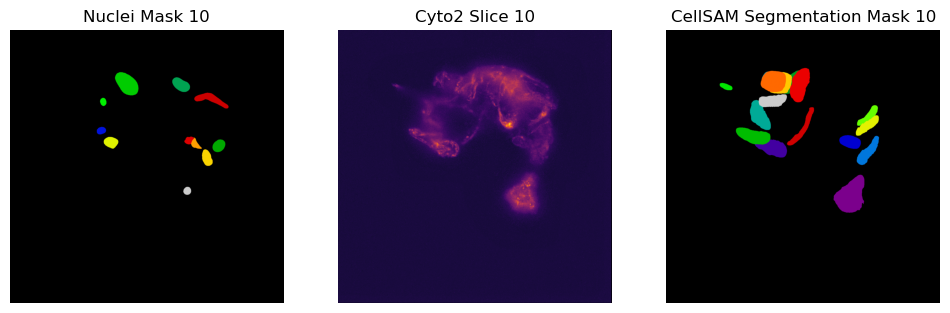

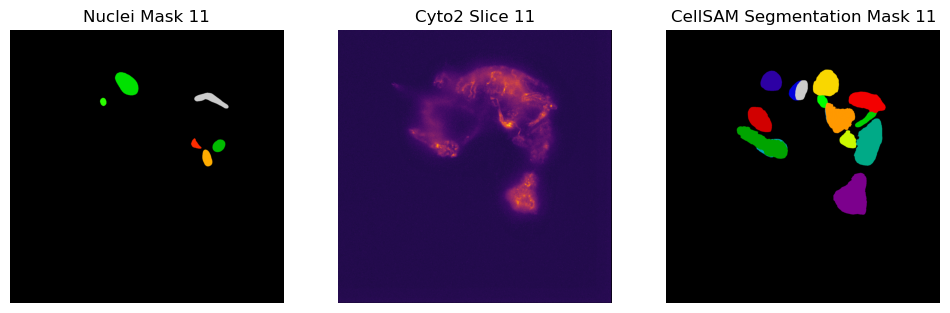

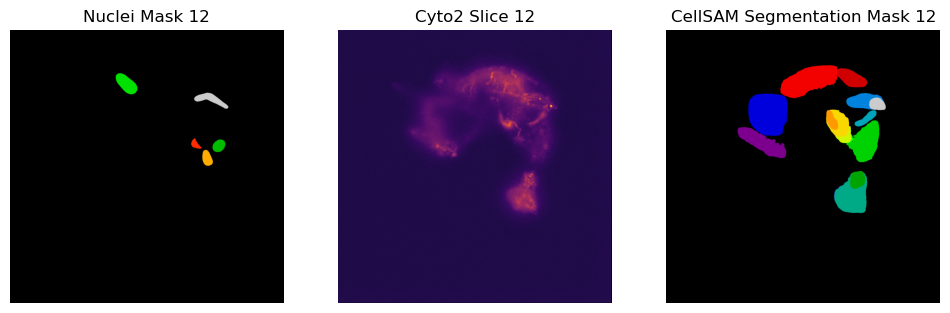

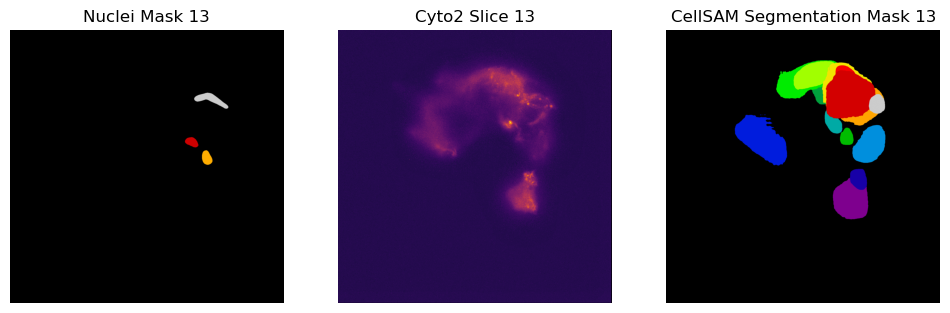

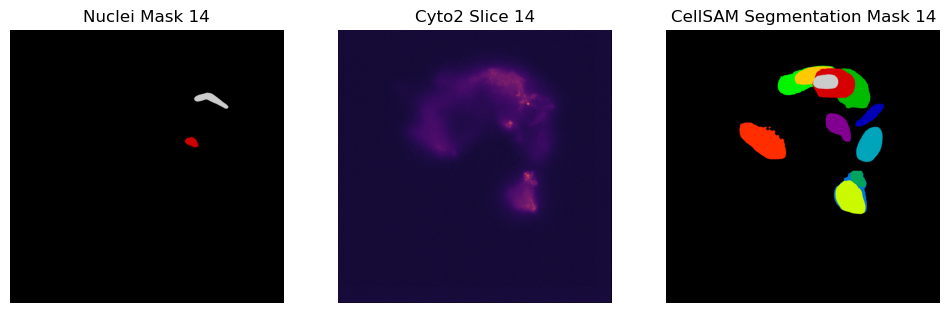

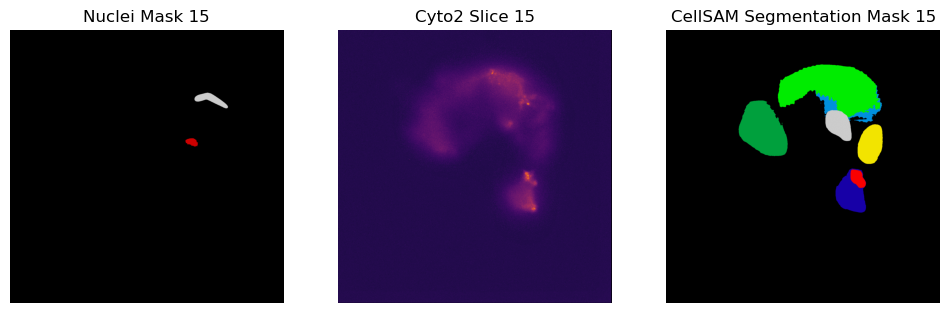

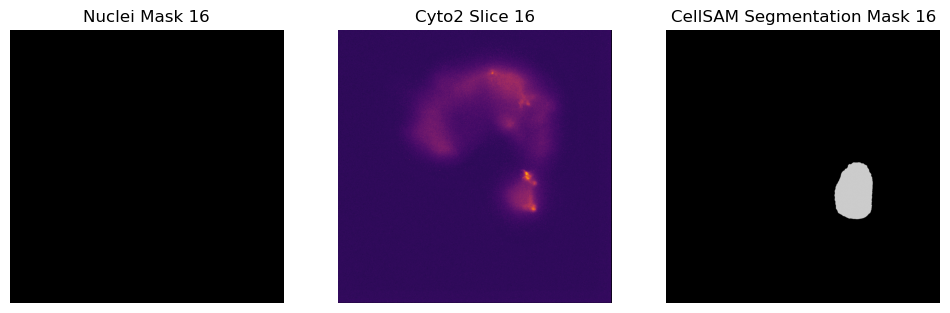

In [32]:
cell_mask = cyto2.copy() * 0
for z in range(cyto2.shape[0]):
    cyto2_slice = cyto2[z, :, :].copy()
    mask = cellsam_pipeline(
        cyto2_slice,
        use_wsi=False,
        low_contrast_enhancement=False,
        gauge_cell_size=False,
    ).astype(np.uint16)
    cell_mask[z, :, :] = mask
cell_mask = cell_mask.astype(np.uint16)

cell_mask, _, _ = skimage.segmentation.relabel_sequential(cell_mask)
# plt.imshow(cell_mask[8], cmap="nipy_spectral")
# plt.title("Relabeled Masks")
# plt.show()
if in_notebook:
    for z in range(cell_mask.shape[0]):
        # Visualize results
        plt.figure(figsize=(12, 6))
        plt.subplot(131)
        plt.imshow(nuclei_mask[z, :, :], cmap="nipy_spectral")
        plt.title(f"Nuclei Mask {z}")
        plt.axis("off")
        plt.subplot(132)
        plt.imshow(cyto2[z, :, :], cmap="inferno")
        plt.title(f"Cyto2 Slice {z}")
        plt.axis("off")
        plt.subplot(133)
        plt.imshow(cell_mask[z, :, :], cmap="nipy_spectral")
        plt.title(f"CellSAM Segmentation Mask {z}")
        plt.axis("off")
        plt.show()

In [17]:
import segment3D.file_io as uSegment3D_fio
import segment3D.filters as uSegment3D_filters
import segment3D.flows as uSegment3D_flows
import segment3D.parameters as uSegment3D_params  # this is useful to call default parameters, and keep track of parameter changes and for saving parameters.
import segment3D.plotting as uSegment3D_plotting
import segment3D.segmentation as uSegment3D_segment
import segment3D.usegment3d as uSegment3D
import segment3D.watershed as uSegment3D_watershed

In [18]:
def orthogonal_views(
    image: np.ndarray,
):
    """
    Generate the 2D slice labels.
    - this transposes the input  volume into xy, xz, yz stacks, then goes slice-by-slice and ensures every ID corresponds to one spatial connected component.
    """
    # xy
    labels_xy = image.copy()
    labels_xy = uSegment3D_filters.filter_2d_label_slices(
        labels_xy, bg_label=0, minsize=8
    )

    # xz
    labels_xz = image.transpose(1, 0, 2).copy()
    labels_xz = uSegment3D_filters.filter_2d_label_slices(
        labels_xz, bg_label=0, minsize=8
    )

    # zy
    labels_zy = image.transpose(0, 2, 1).copy()
    labels_zy = uSegment3D_filters.filter_2d_label_slices(
        labels_zy, bg_label=0, minsize=8
    )

    # yz
    labels_yz = image.transpose(2, 0, 1).copy()
    labels_yz = uSegment3D_filters.filter_2d_label_slices(
        labels_yz, bg_label=0, minsize=8
    )
    # Plot orthogonal views (XY, XZ, YZ) with correct axis orientation, scaling, and matching widths
    voxel_size_xy = 0.1  # replace with pixel size in XY (e.g., um/pixel)
    voxel_size_z = 1.0  # replace with z-step size (e.g., um)

    Z, Y, X = image.shape
    z_mid, y_mid, x_mid = Z // 2, Y // 2, X // 2

    xy = labels_xy[z_mid]  # (Y, X)
    xz = labels_xz[y_mid]  # (Z, X)
    yz = labels_yz[x_mid]  # (Z, Y)
    yz_rot = np.rot90(yz)  # rotate 90° to get (Y, Z)

    max_xy = max(X, Y) * voxel_size_xy
    max_z = Z * voxel_size_z

    extent_xy = [0, max_xy, max_xy, 0]
    extent_xz = [0, max_xy, max_z, 0]  # force X span to match XY width
    extent_zy = [0, max_z, max_xy, 0]

    fig = plt.figure(figsize=(6, 6))

    # Manually position axes to eliminate gaps - adjusted bottom position of top plot
    ax_xz = fig.add_axes([0.05, 0.50, 0.45, 0.45])  # changed from 0.52 to 0.50
    ax_xz.imshow(
        xz, cmap="nipy_spectral", origin="upper", extent=extent_xz, aspect="equal"
    )
    ax_xz.axis("off")

    ax_xy = fig.add_axes([0.05, 0.05, 0.45, 0.45])
    ax_xy.imshow(
        xy, cmap="nipy_spectral", origin="upper", extent=extent_xy, aspect="equal"
    )
    ax_xy.axis("off")

    ax_yz = fig.add_axes([0.52, 0.05, 0.45, 0.45])
    ax_yz.imshow(
        yz_rot, cmap="nipy_spectral", origin="upper", extent=extent_zy, aspect="equal"
    )
    ax_yz.axis("off")

    return fig

In [19]:
from collections import defaultdict

import networkx as nx
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist


def build_complete_bipartite_graph(masks_2d, distance_threshold=None):
    """
    Build a complete bipartite graph from 2D segmentation masks.

    For each pair of consecutive slices, connect EVERY object in slice N
    to EVERY object in slice N+1, computing Euclidean distance between centroids.

    Args:
        masks_2d: List of 2D segmentation masks (numpy arrays)
        distance_threshold: Optional maximum distance to include edges.
                           If None, ALL pairs are connected (truly complete).

    Returns:
        G: NetworkX graph
        df: DataFrame with all edges
    """
    from scipy import ndimage

    G = nx.Graph()
    edges_data = []

    # For each slice, find all objects and their centroids
    slice_objects = {}

    for z, mask in enumerate(masks_2d):
        unique_ids = np.unique(mask)
        unique_ids = unique_ids[unique_ids > 0]  # Remove background

        if len(unique_ids) == 0:
            slice_objects[z] = {}
            continue

        centroids = ndimage.center_of_mass(mask, labels=mask, index=unique_ids)

        slice_objects[z] = {}
        for obj_id, centroid in zip(unique_ids, centroids):
            slice_objects[z][obj_id] = centroid
            G.add_node(
                f"z{z}_id{obj_id}", slice=z, original_label=obj_id, coordinates=centroid
            )

    # Build complete bipartite graph between consecutive slices
    for z in range(len(masks_2d) - 1):
        if z not in slice_objects or (z + 1) not in slice_objects:
            continue

        curr_objects = slice_objects[z]
        next_objects = slice_objects[z + 1]

        if not curr_objects or not next_objects:
            continue

        curr_ids = list(curr_objects.keys())
        next_ids = list(next_objects.keys())

        curr_centroids = np.array([curr_objects[id] for id in curr_ids])
        next_centroids = np.array([next_objects[id] for id in next_ids])

        # Compute all pairwise distances
        distances = cdist(curr_centroids, next_centroids, metric="euclidean")

        # Add edges for ALL pairs (truly complete graph)
        for i, curr_id in enumerate(curr_ids):
            for j, next_id in enumerate(next_ids):
                dist = distances[i, j]

                # Note: distance_threshold is now NOT applied here
                # (use greedy matching threshold instead)

                curr_node = f"z{z}_id{curr_id}"
                next_node = f"z{z + 1}_id{next_id}"

                G.add_edge(
                    curr_node,
                    next_node,
                    weight=dist,
                    slice1=z,
                    slice2=z + 1,
                    original_label1=curr_id,
                    original_label2=next_id,
                )

                edges_data.append(
                    {
                        "index1": curr_node,
                        "index2": next_node,
                        "slice1": z,
                        "slice2": z + 1,
                        "original_label1": curr_id,
                        "original_label2": next_id,
                        "distance": dist,
                        "coordinates1": curr_objects[curr_id],
                        "coordinates2": next_objects[next_id],
                    }
                )

    df = pd.DataFrame(edges_data)
    return G, df


def solve_graph_improved(G, max_distance=100.0, slices=None, verbose=False):
    """
    Solve bipartite matching across consecutive slices using greedy matching
    based on edge weights (distances).

    Instead of Hungarian algorithm (which can force bad matches), greedily match
    objects in order of smallest distance. This ensures we only connect objects
    that are genuinely close.

    Args:
        G: NetworkX graph with edges between different slices
        max_distance: Maximum distance to accept a match.
        slices: Optional list of slice numbers to process
        verbose: Print debugging info

    Returns:
        List of paths, where each path is a list of node IDs
    """

    if G.number_of_nodes() == 0:
        return []

    # Get unique slices from nodes
    all_slices = set()
    for node in G.nodes():
        slice_id = G.nodes[node]["slice"]
        all_slices.add(slice_id)

    slices = sorted(all_slices)

    if len(slices) < 2:
        # Only one slice, each node is its own path
        return [[node] for node in G.nodes()]

    # For each slice, store its nodes
    slice_to_nodes = defaultdict(list)
    for node in G.nodes():
        slice_id = G.nodes[node]["slice"]
        slice_to_nodes[slice_id].append(node)

    # Track assignments across slices
    node_to_trajectory = {}
    trajectory_id_counter = 0
    trajectories = defaultdict(list)

    # Match consecutive slices
    for i in range(len(slices) - 1):
        curr_slice = slices[i]
        next_slice = slices[i + 1]

        curr_nodes = sorted(slice_to_nodes[curr_slice])
        next_nodes = sorted(slice_to_nodes[next_slice])

        if not curr_nodes or not next_nodes:
            continue

        # Get all edges between these slices, sorted by weight
        edges = []
        for curr_node in curr_nodes:
            for next_node in next_nodes:
                if G.has_edge(curr_node, next_node):
                    weight = G[curr_node][next_node]["weight"]
                    edges.append((weight, curr_node, next_node))

        if not edges:
            if verbose:
                print(f"Warning: No edges between slice {curr_slice} and {next_slice}")
            continue

        # Sort by distance (smallest first)
        edges.sort(key=lambda x: x[0])

        matched_curr = set()
        matched_next = set()

        # Priority 1: Match nodes that already have trajectories (prefer continuity)
        priority_edges = []
        new_edges = []

        for dist, curr_node, next_node in edges:
            if dist > max_distance:
                continue
            if curr_node in matched_curr or next_node in matched_next:
                continue

            # Prioritize edges where curr_node already has a trajectory
            if curr_node in node_to_trajectory:
                priority_edges.append((dist, curr_node, next_node))
            else:
                new_edges.append((dist, curr_node, next_node))

        # Match priority edges first (continues existing trajectories)
        for dist, curr_node, next_node in priority_edges:
            if curr_node in matched_curr or next_node in matched_next:
                continue

            traj_id = node_to_trajectory[curr_node]
            node_to_trajectory[next_node] = traj_id
            trajectories[traj_id].append(next_node)
            matched_curr.add(curr_node)
            matched_next.add(next_node)

        # Then match new edges (start new trajectories)
        for dist, curr_node, next_node in new_edges:
            if curr_node in matched_curr or next_node in matched_next:
                continue

            traj_id = trajectory_id_counter
            trajectory_id_counter += 1
            trajectories[traj_id].append(curr_node)
            trajectories[traj_id].append(next_node)
            node_to_trajectory[curr_node] = traj_id
            node_to_trajectory[next_node] = traj_id
            matched_curr.add(curr_node)
            matched_next.add(next_node)

        # Create new trajectories for unmatched next_nodes
        for next_node in next_nodes:
            if next_node not in matched_next and next_node not in node_to_trajectory:
                trajectories[trajectory_id_counter] = [next_node]
                node_to_trajectory[next_node] = trajectory_id_counter
                trajectory_id_counter += 1

    # Add any untracked nodes as single-node paths
    for node in G.nodes():
        if node not in node_to_trajectory:
            trajectories[trajectory_id_counter] = [node]
            trajectory_id_counter += 1

    return list(trajectories.values())


def split_long_trajectories(paths, max_length):
    """
    Split trajectories that exceed max_length into shorter ones.

    Args:
        paths: List of node paths
        max_length: Maximum number of consecutive nodes per trajectory

    Returns:
        List of split trajectories
    """
    split_paths = []

    for path in paths:
        if len(path) <= max_length:
            split_paths.append(path)
        else:
            # Split into chunks of max_length
            for i in range(0, len(path), max_length):
                chunk = path[i : i + max_length]
                if chunk:
                    split_paths.append(chunk)

    return split_paths


def collapse_labels_from_paths(masks_2d, paths):
    """
    Assign unified labels based on trajectories.

    Args:
        masks_2d: List of 2D masks
        paths: List of node paths from solve_graph_improved

    Returns:
        List of 3D masks with unified labels
    """
    # Create mapping from node ID to trajectory label
    node_to_label = {}
    for label_id, path in enumerate(paths):
        for node_id in path:
            node_to_label[node_id] = label_id

    # Relabel each 2D mask
    relabeled_masks = []
    for z, mask in enumerate(masks_2d):
        new_mask = np.zeros_like(mask)

        unique_ids = np.unique(mask)
        unique_ids = unique_ids[unique_ids > 0]

        for obj_id in unique_ids:
            node_id = f"z{z}_id{obj_id}"
            if node_id in node_to_label:
                new_label = node_to_label[node_id]
                new_mask[mask == obj_id] = new_label

        relabeled_masks.append(new_mask)

    return relabeled_masks


def stack_3d_segmentation(relabeled_masks):
    """Stack 2D relabeled masks into 3D volume."""
    return np.stack(relabeled_masks, axis=0)


def remove_single_slice_objects(segmentation_3d):
    """
    Remove objects that only appear in a single z-slice.

    Args:
        segmentation_3d: 3D segmentation array

    Returns:
        Cleaned 3D segmentation with single-slice objects removed
    """
    cleaned = segmentation_3d.copy()

    # Find all unique labels
    unique_labels = np.unique(segmentation_3d)
    unique_labels = unique_labels[unique_labels > 0]

    # For each label, count how many slices it appears in
    for label in unique_labels:
        slices_with_label = np.where(np.any(segmentation_3d == label, axis=(1, 2)))[0]

        # If label only appears in 1 slice, remove it
        if len(slices_with_label) == 1:
            cleaned[segmentation_3d == label] = 0

    return cleaned


def fill_object_gaps(segmentation_3d, max_gap_size=2):
    """
    Fill gaps in object trajectories (missing slices between appearances).

    For example, if object ID 5 appears in slices [10, 11, 14, 15],
    the gap between 11 and 14 will be filled if gap_size <= max_gap_size.

    Args:
        segmentation_3d: 3D segmentation array
        max_gap_size: Maximum number of consecutive missing slices to fill
                     (default: 2, meaning fill gaps of 1-2 slices)

    Returns:
        Filled 3D segmentation
    """
    filled = segmentation_3d.copy()

    # Find all unique labels
    unique_labels = np.unique(segmentation_3d)
    unique_labels = unique_labels[unique_labels > 0]

    for label in unique_labels:
        # Find all slices where this label appears
        slices_with_label = np.where(np.any(segmentation_3d == label, axis=(1, 2)))[0]

        if len(slices_with_label) < 2:
            continue

        # Check for gaps and fill them
        for i in range(len(slices_with_label) - 1):
            curr_slice = slices_with_label[i]
            next_slice = slices_with_label[i + 1]
            gap_size = next_slice - curr_slice - 1

            # If gap is small enough, fill it by interpolating from neighbors
            if 0 < gap_size <= max_gap_size:
                # Get the mask from current and next slice
                curr_mask = segmentation_3d[curr_slice] == label
                next_mask = segmentation_3d[next_slice] == label

                # Interpolate: use union of both masks for gap slices
                combined_mask = curr_mask | next_mask

                for gap_slice in range(curr_slice + 1, next_slice):
                    filled[gap_slice][combined_mask] = label

    return filled


def postprocess_segmentation(
    segmentation_3d, remove_singletons=True, fill_gaps=True, max_gap_size=2
):
    """
    Post-process 3D segmentation to clean up artifacts.

    Args:
        segmentation_3d: 3D segmentation array
        remove_singletons: If True, remove objects that only appear in 1 slice
        fill_gaps: If True, fill small gaps in object trajectories
        max_gap_size: Maximum gap size to fill (only used if fill_gaps=True)

    Returns:
        Cleaned 3D segmentation
    """
    result = segmentation_3d.copy()

    if remove_singletons:
        result = remove_single_slice_objects(result)

    if fill_gaps:
        result = fill_object_gaps(result, max_gap_size)

    return result


def full_pipeline(
    masks_2d, max_match_distance=100.0, max_trajectory_length=None, verbose=True
):
    """
    Complete pipeline: build complete bipartite graph -> solve matching -> relabel.

    Args:
        masks_2d: List of 2D segmentation masks
        max_match_distance: Maximum distance to accept a match (in pixels).
        max_trajectory_length: Optional maximum number of consecutive slices an object
                              can span. If None, no limit. Use to prevent unrealistic
                              tall objects (e.g., set to 10 if cells shouldn't span >10 slices).
        verbose: Print diagnostics

    Returns:
        segmentation_3d: 3D array with unified instance labels across slices
        diagnostics: Dict with stats about the matching
    """
    if verbose:
        print("Building complete bipartite graph...")
    G, df = build_complete_bipartite_graph(masks_2d)

    if verbose:
        print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
        print(f"\nDistance statistics:")
        if len(df) > 0:
            print(f"  Mean distance: {df['distance'].mean():.2f}")
            print(f"  Median distance: {df['distance'].median():.2f}")
            print(f"  Std dev: {df['distance'].std():.2f}")
            print(f"  Min: {df['distance'].min():.2f}, Max: {df['distance'].max():.2f}")
            print(f"  25th percentile: {df['distance'].quantile(0.25):.2f}")
            print(f"  75th percentile: {df['distance'].quantile(0.75):.2f}")

    if verbose:
        print(
            f"\nSolving bipartite matching (max_match_distance={max_match_distance})..."
        )

    paths = solve_graph_improved(G, max_distance=max_match_distance, verbose=verbose)

    # Post-process: split trajectories that are too long
    if max_trajectory_length is not None:
        paths = split_long_trajectories(paths, max_trajectory_length)

    diagnostics = {
        "num_trajectories": len(paths),
        "trajectory_lengths": [len(p) for p in paths],
        "mean_trajectory_length": np.mean([len(p) for p in paths]),
        "distance_stats": {
            "mean": df["distance"].mean() if len(df) > 0 else 0,
            "median": df["distance"].median() if len(df) > 0 else 0,
            "std": df["distance"].std() if len(df) > 0 else 0,
        },
    }

    if verbose:
        print(f"Found {len(paths)} trajectories")
        print(
            f"  Mean trajectory length: {diagnostics['mean_trajectory_length']:.2f} slices"
        )
        print(f"  Max trajectory length: {max(diagnostics['trajectory_lengths'])}")
        single_slice = sum(1 for p in paths if len(p) == 1)
        print(f"  Single-slice trajectories: {single_slice}")
        print("Relabeling masks...")

    relabeled_masks = collapse_labels_from_paths(masks_2d, paths)

    if verbose:
        print("Stacking into 3D volume...")

    segmentation_3d = stack_3d_segmentation(relabeled_masks)

    # Post-process: remove single-slice objects and fill small gaps
    segmentation_3d = postprocess_segmentation(
        segmentation_3d, remove_singletons=True, fill_gaps=True, max_gap_size=2
    )

    return segmentation_3d, diagnostics

In [20]:
# generate the coordinates dataframe for reconstruction
coordinates_df = generate_coordinates_for_reconstruction(cell_mask)
# generate distance pairs dataframe
df = generate_distance_pairs(coordinates_df, x_y_vector_radius_max_constraint=20)
# generate and solve graph to get longest paths
# longest_paths = solve_graph(graph_creation(df))
# # collapse labels based on longest paths and reassign labels in nuclei masks
# image = reassign_labels(cell_mask, collapse_labels(coordinates_df, longest_paths))
# # refine the nuclei masks
# original_methods_cell_mask = run_post_hoc_refinement(
#     mask_image=image,
#     sliding_window_context=3,
# )

# del image, coordinates_df, df, longest_paths

In [21]:
segmentation_3d, diag = full_pipeline(cell_mask, max_match_distance=100)

Building complete bipartite graph...
Graph has 178 nodes and 2096 edges

Distance statistics:
  Mean distance: 380.71
  Median distance: 372.30
  Std dev: 209.35
  Min: 0.94, Max: 941.97
  25th percentile: 214.32
  75th percentile: 553.82

Solving bipartite matching (max_match_distance=100)...
Found 67 trajectories
  Mean trajectory length: 2.66 slices
  Max trajectory length: 15
  Single-slice trajectories: 30
Relabeling masks...
Stacking into 3D volume...


100%|██████████| 25/25 [01:28<00:00,  3.55s/it]


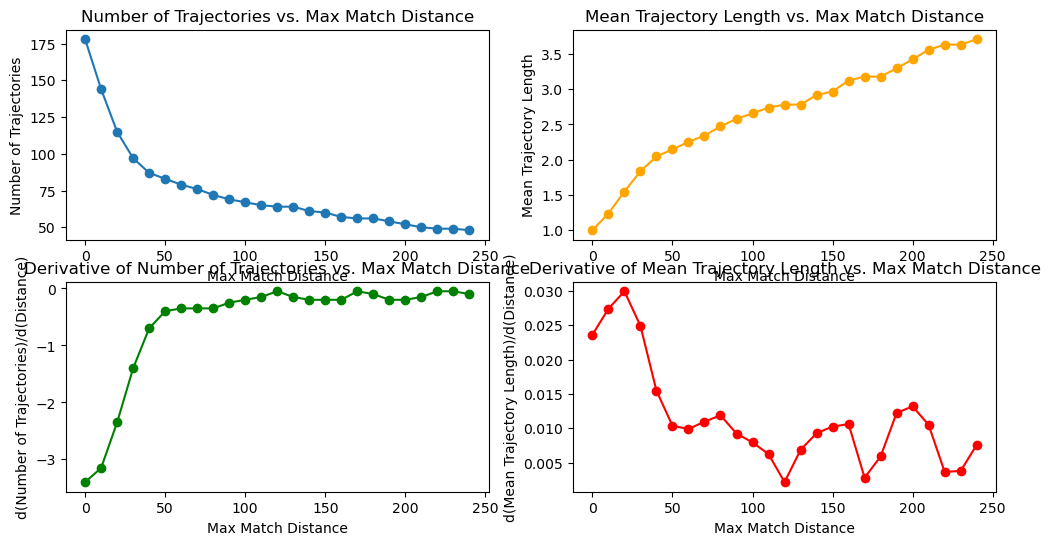

In [22]:
results_dict = {
    "distance": [],
    "num_trajectories": [],
    "mean_trajectory_length": [],
    "mean_distance_stats": [],
    "median_distance_stats": [],
    "std_distance_stats": [],
}
for i in tqdm.tqdm(range(0, 250, 10)):
    _, diag = full_pipeline(cell_mask, max_match_distance=i, verbose=False)
    results_dict["distance"].append(i)
    results_dict["num_trajectories"].append(diag["num_trajectories"])
    results_dict["mean_trajectory_length"].append(diag["mean_trajectory_length"])
    results_dict["mean_distance_stats"].append(
        np.median(diag["distance_stats"]["mean"])
    )
    results_dict["median_distance_stats"].append(
        np.median(diag["distance_stats"]["median"])
    )
    results_dict["std_distance_stats"].append(np.median(diag["distance_stats"]["std"]))

results_df = pd.DataFrame(results_dict)
plt.figure(figsize=(12, 6))
plt.subplot(221)
plt.plot(results_df["distance"], results_df["num_trajectories"], marker="o")
plt.title("Number of Trajectories vs. Max Match Distance")
plt.xlabel("Max Match Distance")
plt.ylabel("Number of Trajectories")
plt.subplot(222)
plt.plot(
    results_df["distance"],
    results_df["mean_trajectory_length"],
    marker="o",
    color="orange",
)
plt.title("Mean Trajectory Length vs. Max Match Distance")
plt.xlabel("Max Match Distance")
plt.ylabel("Mean Trajectory Length")
plt.subplot(223)
# get the dirivative of num_trajectories with respect to distance
derivative_num_trajectories = np.gradient(
    results_df["num_trajectories"], results_df["distance"]
)
plt.plot(results_df["distance"], derivative_num_trajectories, marker="o", color="green")
plt.title("Derivative of Number of Trajectories vs. Max Match Distance")
plt.xlabel("Max Match Distance")
plt.ylabel("d(Number of Trajectories)/d(Distance)")
plt.subplot(224)
# get the derivative of mean_trajectory_length with respect to distance
derivative_mean_trajectory_length = np.gradient(
    results_df["mean_trajectory_length"], results_df["distance"]
)
plt.plot(
    results_df["distance"], derivative_mean_trajectory_length, marker="o", color="red"
)
plt.title("Derivative of Mean Trajectory Length vs. Max Match Distance")
plt.xlabel("Max Match Distance")
plt.ylabel("d(Mean Trajectory Length)/d(Distance)")
plt.show()

In [23]:
segmentation_3d, diag = full_pipeline(
    cell_mask, max_match_distance=75, max_trajectory_length=12, verbose=True
)

Building complete bipartite graph...
Graph has 178 nodes and 2096 edges

Distance statistics:
  Mean distance: 380.71
  Median distance: 372.30
  Std dev: 209.35
  Min: 0.94, Max: 941.97
  25th percentile: 214.32
  75th percentile: 553.82

Solving bipartite matching (max_match_distance=75)...
Found 74 trajectories
  Mean trajectory length: 2.41 slices
  Max trajectory length: 12
  Single-slice trajectories: 36
Relabeling masks...
Stacking into 3D volume...


In [24]:
cell_mask_output = pathlib.Path(f"{mask_path}/cell_mask.tiff")
tifffile.imwrite(cell_mask_output, segmentation_3d)

In [25]:
segmentation_3d_post_hoc = run_post_hoc_refinement(
    mask_image=segmentation_3d,
    sliding_window_context=3,
)
cell_mask_output = pathlib.Path(f"{mask_path}/cell_mask_post_hoc.tiff")
tifffile.imwrite(cell_mask_output, segmentation_3d_post_hoc)

Code pulled from: https://github.com/DanuserLab/u-segment3D/blob/6c64db1fe6aa5e704467ea26b7a61d7fb610996a/tutorials/technical/reconstruct_LateralRootPrimordia_from_2D_slices.py#L4

In [26]:
# """
# Generate the 2D slice labels.
# - this transposes the input  volume into xy, xz, yz stacks, then goes slice-by-slice and ensures every ID corresponds to one spatial connected component.
# """
# # xy
# labels_xy = segmentation_3d.copy()
# labels_xy = uSegment3D_filters.filter_2d_label_slices(labels_xy, bg_label=0, minsize=8)

# # xz
# labels_xz = segmentation_3d.transpose(1, 0, 2).copy()
# labels_xz = uSegment3D_filters.filter_2d_label_slices(labels_xz, bg_label=0, minsize=8)

# # zy
# labels_zy = segmentation_3d.transpose(0, 2, 1).copy()
# labels_zy = uSegment3D_filters.filter_2d_label_slices(labels_zy, bg_label=0, minsize=8)

# # yz
# labels_yz = segmentation_3d.transpose(2, 0, 1).copy()
# labels_yz = uSegment3D_filters.filter_2d_label_slices(labels_yz, bg_label=0, minsize=8)
# # Get the default parameters.
# indirect_aggregation_params = uSegment3D_params.get_2D_to_3D_aggregation_params()

# # e.g. using  diffusion skeleton
# indirect_aggregation_params["indirect_method"]["dtform_method"] = (
#     "cellpose_skel"  # this will use our exact solver of heat equation. with a fixed central point
# )
# # indirect_aggregation_params['indirect_method']['dtform_method'] = 'fmm_skel' # this will use our exact solver of heat equation. with a fixed central point
# indirect_aggregation_params["indirect_method"]["smooth_skel_sigma"] = (
#       # 1 or 2 is good ?
# )
# indirect_aggregation_params["gradient_descent"]["gradient_decay"] = (
#     0.25  # we used 0.0 for cellpose_improve in the paper
# )

# # set the gradient descent parameters
# indirect_aggregation_params["gradient_descent"]["n_iter"] = 250
# indirect_aggregation_params["gradient_descent"]["momenta"] = (
#     0.99  # help boost the splitting
# )

# # we can visualize the dynamics
# indirect_aggregation_params["gradient_descent"]["debug_viz"] = False
# segmentation3D, (probability3D, gradients3D) = (
#     uSegment3D.aggregate_2D_to_3D_segmentation_indirect_method(
#         segmentations=[
#             labels_xy,
#             labels_xz,
#             labels_yz,
#         ],
#         img_xy_shape=cell_mask.shape,
#         precomputed_binary=cell_mask > 0,  # we know the foreground
#         params=indirect_aggregation_params,
#         savefolder=None,
#         basename=None,
#     )
# )
# plt.imshow(segmentation3D[8], cmap="nipy_spectral")
# plt.title("Relabeled Masks")
# plt.show()

In [27]:
# # remove small objects
# segmentation3D = uSegment3D_filters.remove_small_labels(segmentation_3d, min_size=250)
# plt.imshow(segmentation3D[8], cmap="nipy_spectral")
# plt.title("Relabeled Masks")
# plt.show()

## Match the nuclei labels to the cell labels
Essentially the nuclei and cell segmentations are run independently.
We then have to match which nucleus belongs to which cell.
This is done by looking at the spatial proximity of the centroids of each object in 3D space.

We also run into potential issues where a cell might not have a nucleus, or a nucleus might not have a cell.
We also might run into issues where there are multiple nuclei in a single cell.
This implies that the singel-cell segmentation is not perfect.
We will need to perform a post-hoc refinement step to try and clean up these issues.
To be able to do this we must first identify the problematic cells/nuclei then refine them.

In [28]:
num_of_nuclei = len(np.unique(nuclei_mask)) - 1
num_of_cells = len(np.unique(segmentation_3d)) - 1
print(f"Number of nuclei: {num_of_nuclei}")
print(f"Number of cells: {num_of_cells}")

Number of nuclei: 19
Number of cells: 37


In [29]:
# find a cell per nucleus
nucleus_centroids = skimage.measure.regionprops_table(
    nuclei_mask, properties=["label", "centroid"]
)
nucleus_centroids_df = pd.DataFrame(nucleus_centroids)

cell_centroids = skimage.measure.regionprops_table(
    segmentation_3d, properties=["label", "centroid", "bbox"]
)
cell_centroids_df = pd.DataFrame(cell_centroids)

In [30]:
# check pairwide to see if the centroid of a nucleus is within a cell
nucleus_to_cell_mapping = {}
for _, nucleus_row in nucleus_centroids_df.iterrows():
    nucleus_label = nucleus_row["label"]
    nucleus_centroid = np.array(
        [
            nucleus_row["centroid-0"],
            nucleus_row["centroid-1"],
            nucleus_row["centroid-2"],
        ]
    )
    for _, cell_row in cell_centroids_df.iterrows():
        cell_label = cell_row["label"]
        cell_bbox = cell_row[
            ["bbox-0", "bbox-1", "bbox-2", "bbox-3", "bbox-4", "bbox-5"]
        ].values
        # check if nucleus centroid is within cell bbox
        if (
            nucleus_centroid[0] >= cell_bbox[0]
            and nucleus_centroid[0] <= cell_bbox[3]
            and nucleus_centroid[1] >= cell_bbox[1]
            and nucleus_centroid[1] <= cell_bbox[4]
            and nucleus_centroid[2] >= cell_bbox[2]
            and nucleus_centroid[2] <= cell_bbox[5]
        ):
            nucleus_to_cell_mapping[nucleus_label] = cell_label
            break
nucleus_to_cell_mapping

{1.0: 6.0,
 3.0: 7.0,
 4.0: 14.0,
 6.0: 2.0,
 7.0: 2.0,
 8.0: 13.0,
 9.0: 15.0,
 11.0: 4.0,
 12.0: 15.0,
 13.0: 14.0,
 14.0: 15.0,
 15.0: 42.0,
 17.0: 42.0,
 18.0: 32.0,
 19.0: 2.0}

In [31]:
cell_centroids_df

,label,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5
0,2,7.733940,936.389229,1036.520195,2,799,931,14,1066,1137
1,3,15.305661,922.901845,1048.845411,14,745,946,17,1065,1162
2,4,3.598178,402.411361,494.423572,2,322,331,6,485,617
3,6,4.225091,299.327202,641.218784,2,229,562,7,382,719
4,7,2.831515,352.935073,992.301518,2,248,897,5,431,1057
5,8,2.395004,410.759676,622.838776,2,353,576,4,482,672
6,9,2.356932,474.854968,719.479702,2,428,658,4,523,779
7,10,3.918254,333.963573,793.386625,3,248,713,6,445,865
8,11,3.558098,737.714225,1111.194259,3,703,1066,5,776,1154
9,13,4.919851,303.244464,967.897706,4,251,910,7,364,1028


## run the mask reassignment function (post-hoc)
### This needs to occur after both nuclei and cell segmentations are done

In [ ]:
# cell_df = get_labels_for_post_hoc_reassignment(
#     compartment_mask=cell_mask, compartment_name="cell"
# )
# nuclei_df = get_labels_for_post_hoc_reassignment(
#     compartment_mask=nuclei_mask, compartment_name="nuclei"
# )

In [ ]:
# nuclei_mask, reassigned_nuclei_df = run_post_hoc_mask_reassignment(
#     nuclei_mask=nuclei_mask,
#     cell_mask=cell_mask,
#     nuclei_df=nuclei_df,
#     cell_df=cell_df,
#     return_dataframe=True,
# )

## Cytoplasm Segmentation

In [ ]:
# cytoplasm_mask = create_cytoplasm_masks(
#     nuclei_masks=nuclei_mask,
#     cell_masks=cell_mask,
# )

## Organoid segmentation (derived from cell segmentation)

In [ ]:
# # convert the cell masks to binary masks
# cell_binary_mask = cell_mask.copy()
# cell_binary_mask[cell_binary_mask > 0] = 1
# # dilate the cell masks slightly
# cell_binary_mask = skimage.morphology.binary_dilation(
#     cell_binary_mask, skimage.morphology.ball(10)
# )
# # convert back to instance mask
# # make sure each instance has a unique integer label
# organoid_mask = skimage.measure.label(cell_binary_mask)

## Save the segmented masks

In [ ]:
# nuclei_mask_output = pathlib.Path(f"{mask_path}/nuclei_mask.tiff")
cell_mask_output = pathlib.Path(f"{mask_path}/cell_mask.tiff")
# cytoplasm_mask_output = pathlib.Path(f"{mask_path}/cytoplasm_mask.tiff")
# organoid_mask_output = pathlib.Path(f"{mask_path}/organoid_mask.tiff")
# tifffile.imwrite(nuclei_mask_output, nuclei_mask)
tifffile.imwrite(cell_mask_output, cell_mask)
# tifffile.imwrite(cytoplasm_mask_output, cytoplasm_mask)
# # tifffile.imwrite(organoid_mask_output, organoid_mask)

In [ ]:
# end_mem = psutil.Process(os.getpid()).memory_info().rss / 1024**2
# end_time = time.time()
# print(f"""
#     Memory and time profiling for the run:\n
#     Memory usage: {end_mem - start_mem:.2f} MB\n
#     Time:\n
#     --- %s seconds --- % {(end_time - start_time)}\n
#     --- %s minutes --- % {((end_time - start_time) / 60)}\n
#     --- %s hours --- % {((end_time - start_time) / 3600)}
# """)